<a href="https://colab.research.google.com/github/krmonline/Sentiment-Analysis-in-Social-Networks/blob/master/w2vClassification.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [43]:
!pip install pythainlp
!pip install emoji
!pip install deepcut

     |████████████████████████████████| 51kB 1.7MB/s 
  Created wheel for emoji: filename=emoji-0.5.4-cp36-none-any.whl size=42176 sha256=3ef59021c7957b3f19c7addec8193882e0abdbcb6b9e29c16302a642a1f5b99d
  Stored in directory: /root/.cache/pip/wheels/2a/a9/0a/4f8e8cce8074232aba240caca3fade315bb49fac68808d1a9c
Successfully built emoji
     |████████████████████████████████| 2.0MB 2.7MB/s 


In [0]:
import pythainlp.word_vector
import pandas as pd

In [34]:
pythainlp.word_vector.similarity("คน", "มนุษย์")

/usr/local/lib/python3.6/dist-packages/gensim/matutils.py:737: FutureWarning: Conversion of the second argument of issubdtype from `int` to `np.signedinteger` is deprecated. In future, it will be treated as `np.int64 == np.dtype(int).type`.
  if np.issubdtype(vec.dtype, np.int):


0.2504981

In [35]:
model = pythainlp.word_vector.get_model()

/usr/local/lib/python3.6/dist-packages/smart_open/smart_open_lib.py:253: UserWarning: This function is deprecated, use smart_open.open instead. See the migration notes for details: https://github.com/RaRe-Technologies/smart_open/blob/master/README.rst#migrating-to-the-new-open-function
  'See the migration notes for details: %s' % _MIGRATION_NOTES_URL


In [36]:
thai2dict = {}
for word in model.index2word:
    thai2dict[word] = model[word]
thai2vec = pd.DataFrame.from_dict(thai2dict,orient='index')
thai2vec.head(10)

,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19,20,21,22,23,24,25,26,27,28,29,30,31,32,33,34,35,36,37,38,39,...,260,261,262,263,264,265,266,267,268,269,270,271,272,273,274,275,276,277,278,279,280,281,282,283,284,285,286,287,288,289,290,291,292,293,294,295,296,297,298,299
ที่,0.308956,-0.097699,0.116745,0.215612,0.015768,-0.064163,0.062168,0.039649,0.864940,0.846904,-0.080623,-0.231181,-0.092922,0.295904,-0.043141,-0.095836,0.088743,0.077047,-0.059335,0.022008,-0.045684,0.251084,-0.004513,0.213463,-0.044485,-0.441761,-0.063019,-0.412640,0.116379,-0.387046,0.034444,-0.043999,0.011384,-0.140900,-0.395825,0.237268,0.270278,0.216423,-0.034941,1.378542,...,0.086272,0.410396,-0.001171,0.009646,0.169346,0.172114,0.155705,-0.005084,-0.189634,0.138100,0.197152,-0.593183,-0.050520,-0.232437,0.316324,-0.298040,0.035917,-0.509016,0.221730,-0.211563,-0.007943,-0.158455,0.073451,0.260001,0.074339,0.013533,0.068816,0.402744,0.014355,-0.351401,-0.142418,0.033241,0.171581,-0.624864,-0.009358,0.449131,0.120130,-0.122195,-0.450617,-0.071318
และ,0.010751,-0.618971,0.129665,0.035460,-0.007560,0.027607,0.397824,0.026543,0.254075,0.168328,-0.098588,0.257041,-0.056433,0.004745,-0.194496,-0.094631,-0.223221,0.137139,-0.072942,0.002684,-0.078874,0.010818,-0.371821,0.222702,-0.131057,-0.178166,0.007801,-0.393077,0.529949,-0.310193,0.013337,-0.018138,-0.300043,-0.050325,-0.551239,0.283270,-0.243382,0.377265,0.139683,0.590561,...,0.018532,-0.471577,0.079897,-0.019969,0.066242,0.034164,0.059199,-0.130565,-0.201851,0.071434,-0.553549,-0.957159,-0.120453,-0.170949,0.513533,-0.167251,0.030702,-0.031545,0.589607,-0.029119,-0.081944,-0.133871,-0.175475,0.175725,0.032841,-0.080204,-0.087022,0.375683,0.090828,-0.180471,-0.105786,0.180930,-0.101630,0.070885,-0.037263,0.183606,-0.049088,-0.672288,-1.293044,0.592576
เป็น,-0.015736,-0.258926,0.052953,0.153728,-0.005985,-0.021081,0.041088,0.057312,1.633230,0.442729,-0.119677,-0.250198,-0.163293,0.259298,0.314523,-0.171628,0.000620,0.149310,0.045131,0.002716,0.033260,0.021520,-0.245065,0.229370,-0.125458,-0.228873,0.012631,0.338290,0.127649,-0.358579,0.020668,-0.405923,-0.023469,-0.127814,0.082412,0.051234,-0.303059,0.158995,-0.093958,0.103708,...,-0.081273,0.817347,-0.079280,-0.044231,0.064045,0.191203,0.109252,0.096903,-0.224083,0.174756,0.877677,-0.680886,-0.014604,-0.247449,-0.561851,-0.516297,0.095236,-0.796393,-0.389905,-0.138541,0.023499,0.167832,0.016259,0.168277,0.063619,-0.019294,-0.102617,0.296282,0.423037,-0.279272,-0.009408,-0.252576,-0.305512,0.372542,0.049151,0.568470,0.266586,0.400800,-0.784650,0.197369
ของ,-0.189711,-0.174774,0.171124,-0.186771,0.054294,-0.114150,-1.109456,-0.094466,-0.447015,0.042377,-0.064146,-0.149785,-0.093186,-0.354552,0.237786,-0.078743,-0.107498,0.129285,-0.053666,-0.019932,-0.059581,0.293966,-0.231959,0.040548,-0.113000,-0.299660,-0.066242,-0.208456,-0.022088,-0.340317,0.085374,-0.036507,-2.652814,-0.037416,-0.429546,0.330746,-0.494577,0.118136,0.219643,0.443018,...,0.081878,0.603002,0.074993,0.020903,0.132566,0.015298,0.062580,-0.213313,-0.155607,0.089085,-0.410915,-0.908669,-0.051955,-0.219557,0.248354,-0.214270,0.068104,-0.181821,-0.020594,-0.116557,-0.150756,-0.271633,-0.262408,0.253101,0.098220,-0.000184,0.096545,0.444684,-0.306692,-0.320713,-0.168676,-0.148738,0.680404,0.097702,0.020270,0.182967,-0.083949,0.006287,-0.707434,-0.070234
มี,-0.156962,-0.231863,0.080312,0.323157,0.215695,0.055145,0.420794,0.016842,0.256759,0.832864,-0.019295,-0.216187,-0.084874,0.490498,-0.056507,-0.127134,-0.142764,0.056968,-0.049709,0.016941,0.052464,0.290505,0.137538,0.533145,-0.000178,-0.248639,-0.038150,-0.213958,-0.000181,-0.272026,0.036652,0.001714,0.095409,-0.112760,-0.386491,-0.063893,-0.213437,0.597442,0.022917,0.260411,...,-0.070774,0.311335,0.066876,-0.063675,0.028047,0.141558,0.106993,-0.113822,-0.293616,0.181610,0.515976,-0.932181,-0.003411,-0.186245,-0.664680,-0.025371,0.222201,-0.795720,0.366739,0.150896,0.263638,-0.137672,-0.390320,0.123317,0.089979,0.119934,-0.029731,0.2240

In [0]:
all_df = pd.read_csv("https://raw.githubusercontent.com/PyThaiNLP/wisesight-sentiment/master/kaggle-competition/train.txt",names=['texts'])
all_df['lab'] = pd.read_csv("https://raw.githubusercontent.com/PyThaiNLP/wisesight-sentiment/master/kaggle-competition/train_label.txt",names=['lab'])
test_df = pd.read_csv("https://raw.githubusercontent.com/PyThaiNLP/wisesight-sentiment/master/kaggle-competition/test.txt",names=['texts'])
test_df['real'] = pd.read_csv("https://raw.githubusercontent.com/PyThaiNLP/wisesight-sentiment/master/kaggle-competition/test_label.txt",names=['real'])

In [0]:
all_df["processed"] = all_df.texts.map(lambda x: "|".join(pythainlp.tokenize.word_tokenize(x,engine='newmm')))
test_df["processed"] = test_df.texts.map(lambda x: "|".join(pythainlp.tokenize.word_tokenize(x,engine='newmm')))

In [0]:
import collections
import numpy as np
import numpy.random
import keras.preprocessing
import pandas as pd
import pickle
import glob
import deepcut
import re
import random
from pathlib import Path
from keras.models import Sequential, Model
from keras.layers import Embedding, Reshape, Activation, Input, Dense,GRU,Reshape,TimeDistributed,Bidirectional,Dropout,Masking,Flatten
#from keras_contrib.layers import CRF
from keras.preprocessing import sequence
from keras.utils.np_utils import to_categorical
from keras.optimizers import Adam
from keras.callbacks import ModelCheckpoint, TensorBoard
from keras import backend as K
from pythainlp.tokenize import word_tokenize
import matplotlib.pyplot as plt

In [129]:
max_length = 1000
embedding_matrix = thai2vec.values
del cls_model
cls_model = Sequential()
cls_model.add(Embedding(len(embedding_matrix), 300,weights=[embedding_matrix], input_length=max_length))
cls_model.add(Dropout(0.5))
cls_model.add(Flatten())
cls_model.add(Dense(4, activation='softmax'))
cls_model.compile(loss='categorical_crossentropy',optimizer=Adam(lr=0.01), metrics=['accuracy'])
cls_model.summary()
val_loss = []
loss = []
acc = []
val_acc = []

Model: "sequential_5"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_4 (Embedding)      (None, 1000, 300)         15407400  
_________________________________________________________________
dropout_4 (Dropout)          (None, 1000, 300)         0         
_________________________________________________________________
flatten_4 (Flatten)          (None, 300000)            0         
_________________________________________________________________
dense_4 (Dense)              (None, 4)                 1200004   
Total params: 16,607,404
Trainable params: 16,607,404
Non-trainable params: 0
_________________________________________________________________


In [0]:
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(all_df.processed, all_df.lab, test_size=0.33, random_state=42)

In [59]:
X_train.shape,X_test.shape

((16122,), (7941,))

In [0]:
id2w = thai2vec.index.values
w2id = {}
for i in range(len(id2w)):
  w2id[id2w[i]] = i

In [116]:
tmp2 = []
j = 0
for i in X_train.values:
  j = j +1
  print(j)
  tmp = []
  for x in i.split("|"):
    if x in id2w:
      tmp.append(w2id[x])
    else:
      tmp.append(9858)
  tmp2.append(tmp)

Streaming output truncated to the last 5000 lines.
11124
11125
11126
11127
11128
11129
11130
11131
11132
11133
11134
11135
11136
11137
11138
11139
11140
11141
11142
11143
11144
11145
11146
11147
11148
11149
11150
11151
11152
11153
11154
11155
11156
11157
11158
11159
11160
11161
11162
11163
11164
11165
11166
11167
11168
11169
11170
11171
11172
11173
11174
11175
11176
11177
11178
11179
11180
11181
11182
11183
11184
11185
11186
11187
11188
11189
11190
11191
11192
11193
11194
11195
11196
11197
11198
11199
11200
11201
11202
11203
11204
11205
11206
11207
11208
11209
11210
11211
11212
11213
11214
11215
11216
11217
11218
11219
11220
11221
11222
11223
11224
11225
11226
11227
11228
11229
11230
11231
11232
11233
11234
11235
11236
11237
11238
11239
11240
11241
11242
11243
11244
11245
11246
11247
11248
11249
11250
11251
11252
11253
11254
11255
11256
11257
11258
11259
11260
11261
11262
11263
11264
11265
11266
11267
11268
11269
11270
11271
11272
11273
11274
11275
11276
11277
11278
11279
11280
11281
1

In [120]:
X_train = sequence.pad_sequences(tmp2, maxlen=max_length)
X_train.shape

(16122, 1000)

In [133]:
tmp2 = []
j = 0
for i in X_test.values:
  j = j +1
  print(j)
  tmp = []
  for x in i.split("|"):
    if x in id2w:
      tmp.append(w2id[x])
    else:
      tmp.append(9858)
  tmp2.append(tmp)

Streaming output truncated to the last 5000 lines.
2943
2944
2945
2946
2947
2948
2949
2950
2951
2952
2953
2954
2955
2956
2957
2958
2959
2960
2961
2962
2963
2964
2965
2966
2967
2968
2969
2970
2971
2972
2973
2974
2975
2976
2977
2978
2979
2980
2981
2982
2983
2984
2985
2986
2987
2988
2989
2990
2991
2992
2993
2994
2995
2996
2997
2998
2999
3000
3001
3002
3003
3004
3005
3006
3007
3008
3009
3010
3011
3012
3013
3014
3015
3016
3017
3018
3019
3020
3021
3022
3023
3024
3025
3026
3027
3028
3029
3030
3031
3032
3033
3034
3035
3036
3037
3038
3039
3040
3041
3042
3043
3044
3045
3046
3047
3048
3049
3050
3051
3052
3053
3054
3055
3056
3057
3058
3059
3060
3061
3062
3063
3064
3065
3066
3067
3068
3069
3070
3071
3072
3073
3074
3075
3076
3077
3078
3079
3080
3081
3082
3083
3084
3085
3086
3087
3088
3089
3090
3091
3092
3093
3094
3095
3096
3097
3098
3099
3100
3101
3102
3103
3104
3105
3106
3107
3108
3109
3110
3111
3112
3113
3114
3115
3116
3117
3118
3119
3120
3121
3122
3123
3124
3125
3126
3127
3128
3129
3130
3131
3132

In [135]:
X_test = sequence.pad_sequences(tmp2, maxlen=max_length)
X_test.shape

(7941, 1000)

In [0]:
y_train = pd.get_dummies(y_train, prefix='y')
y_test = pd.get_dummies(y_test, prefix='y')

In [144]:
cls_model.fit(X_train,y_train,validation_data=[X_test,y_test])

Train on 16122 samples, validate on 7941 samples
Epoch 1/1
16122/16122 [==============================] - 168s 10ms/step - loss: 1.6660 - accuracy: 0.8114 - val_loss: 6.6456 - val_accuracy: 0.6228


In [0]:
val_loss = val_loss + cls_model.history.history['val_loss']
loss = loss + cls_model.history.history['loss']
acc = acc + cls_model.history.history['accuracy']
val_acc = val_acc + cls_model.history.history['val_accuracy']

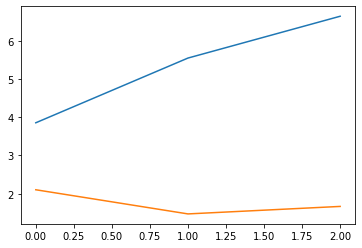

In [146]:
plt.plot(val_loss)
plt.plot(loss)

In [147]:
tmp2 = []
j = 0
for i in test_df.processed.values:
  j = j +1
  print(j)
  tmp = []
  for x in i.split("|"):
    if x in id2w:
      tmp.append(w2id[x])
    else:
      tmp.append(9858)
  tmp2.append(tmp)
X_test2 = sequence.pad_sequences(tmp2, maxlen=max_length)
X_test2.shape

1
2
3
4
5
6
7
8
9
10
11
12
13
14
15
16
17
18
19
20
21
22
23
24
25
26
27
28
29
30
31
32
33
34
35
36
37
38
39
40
41
42
43
44
45
46
47
48
49
50
51
52
53
54
55
56
57
58
59
60
61
62
63
64
65
66
67
68
69
70
71
72
73
74
75
76
77
78
79
80
81
82
83
84
85
86
87
88
89
90
91
92
93
94
95
96
97
98
99
100
101
102
103
104
105
106
107
108
109
110
111
112
113
114
115
116
117
118
119
120
121
122
123
124
125
126
127
128
129
130
131
132
133
134
135
136
137
138
139
140
141
142
143
144
145
146
147
148
149
150
151
152
153
154
155
156
157
158
159
160
161
162
163
164
165
166
167
168
169
170
171
172
173
174
175
176
177
178
179
180
181
182
183
184
185
186
187
188
189
190
191
192
193
194
195
196
197
198
199
200
201
202
203
204
205
206
207
208
209
210
211
212
213
214
215
216
217
218
219
220
221
222
223
224
225
226
227
228
229
230
231
232
233
234
235
236
237
238
239
240
241
242
243
244
245
246
247
248
249
250
251
252
253
254
255
256
257
258
259
260
261
262
263
264
265
266
267
268
269
270
271
272
273
274
275
276
277


(2674, 1000)

In [0]:
y_pred = cls_model.predict_classes(X_test2)
y_real = test_df.real

In [0]:
from sklearn.metrics import classification_report

In [0]:
tmp = {'neg':0,'neu':1,'pos':2,'q':3}
tmp2 = []
for i in y_real.values:
  tmp2.append([tmp[i]])
y_real = tmp2

In [166]:
print(classification_report(y_real,y_pred))

              precision    recall  f1-score   support

           0       0.61      0.68      0.64       683
           1       0.68      0.73      0.70      1456
           2       0.47      0.24      0.32       478
           3       0.14      0.32      0.20        57

    accuracy                           0.62      2674
   macro avg       0.48      0.49      0.46      2674
weighted avg       0.62      0.62      0.61      2674

